In [391]:
# Import Libraries
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import stats
import pyspark as ps    # for the pyspark suitefrom collections import Counter
import matplotlib.pyplot as plt
from collections import Counter
plt.style.use('ggplot')

In [543]:
# Import Custom Modules
from src.eda_helper import *

In [93]:
# Create spark session
spark = ps.sql.SparkSession.builder \
            .master("local[4]") \
            .appName("capstone1") \
            .getOrCreate()
sc = spark.sparkContext

In [542]:
ls data/


AMAZON_FASHION_5.json  All_Beauty_5.json      Books_5.json


In [5]:
# beauty ratings
path_beauty = "data/All_Beauty_5.json"


## Explore data in Beauty

In [6]:
# Create Spark DF
beauty_df = spark.read.json(path_beauty)
# Create Spark SQL
beauty_df.createOrReplaceTempView('beauty')
# Create Spark RDD
beauty_rdd = sc.textFile(path_beauty)

In [7]:
beauty_df.printSchema()

print(beauty_df.count())

root
 |-- asin: string (nullable = true)
 |-- image: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- style: struct (nullable = true)
 |    |-- Color:: string (nullable = true)
 |    |-- Design:: string (nullable = true)
 |    |-- Flavor:: string (nullable = true)
 |    |-- Scent Name:: string (nullable = true)
 |    |-- Size:: string (nullable = true)
 |    |-- Style Name:: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- verified: boolean (nullable = true)
 |-- vote: string (nullable = true)

5269


In [8]:
beauty_rdd.take(1)

['{"overall": 5.0, "verified": true, "reviewTime": "09 1, 2016", "reviewerID": "A3CIUOJXQ5VDQ2", "asin": "B0000530HU", "style": {"Size:": " 7.0 oz", "Flavor:": " Classic Ice Blue"}, "reviewerName": "Shelly F", "reviewText": "As advertised. Reasonably priced", "summary": "Five Stars", "unixReviewTime": 1472688000}']

In [9]:
# Map each RDD item to JSON
beauty_rdd_json = beauty_rdd.map(parse_json)

# Sample View
beauty_rdd_json.take(1)

[{'overall': 5.0,
  'verified': True,
  'reviewTime': '09 1, 2016',
  'reviewerID': 'A3CIUOJXQ5VDQ2',
  'asin': 'B0000530HU',
  'style': {'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice Blue'},
  'reviewerName': 'Shelly F',
  'reviewText': 'As advertised. Reasonably priced',
  'summary': 'Five Stars',
  'unixReviewTime': 1472688000}]

## How is the ratings distributed


### Extract 'overall' key from JSON Obects

In [31]:
overall_beauty = (beauty_rdd_json.filter(lambda row: row['verified'])
                  .map(lambda row: (row['overall']))
overall_beauty.count()

4280

In [32]:
overall_beauty.take(10)

[5.0, 5.0, 1.0, 5.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [251]:
mean_beauty = overall_beauty.mean()
mean_beauty

4.814252336448603

In [252]:
std_beauty = overall_beauty.stdev()
std_beauty

0.7304029433749584

###  Pie Chart of overall_tags in Beauty

In [34]:
bins = [1,2,3,4,5]
cnt = Counter(overall_beauty.collect())
cnt

Counter({5.0: 3931, 1.0: 111, 2.0: 39, 4.0: 164, 3.0: 35})

In [476]:
# Create DF of ratings count
df_cnt_beauty = pd.DataFrame({'ratings': list(cnt.keys()),
                             'count': list(cnt.values())
})
df_cnt_beauty = df_cnt_beauty.sort_values(by=['ratings'],ascending=False)
df_cnt_beauty

,ratings,count
0,5.0,3931
3,4.0,164
4,3.0,35
2,2.0,39
1,1.0,111


Text(0.5, 1.0, 'Ratings count in Beauty')

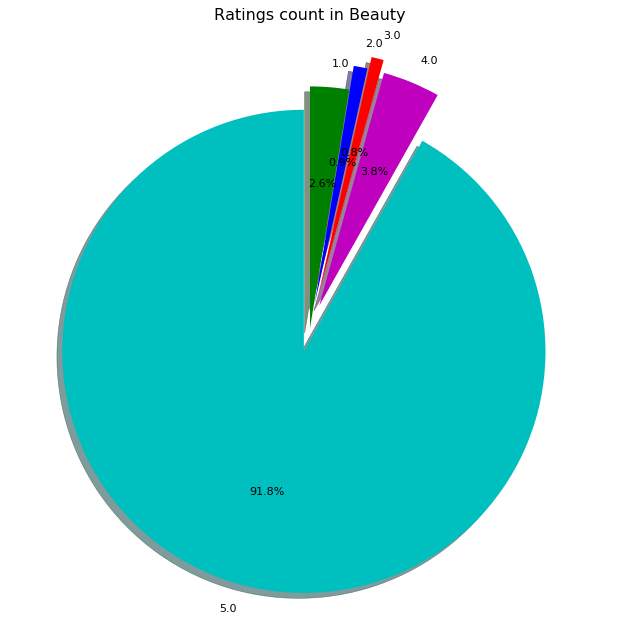

In [193]:
fig, ax = plt.subplots(figsize=(14, 10), dpi=80)
labels = df_cnt_beauty['ratings'].values
sizes  = df_cnt_beauty['count'].values
cols = ['c','m','r','b','g']
# ax.bar(df_ratings['ratings'],df_ratings['count'])
ax.pie(sizes,
        labels=labels,
        startangle=90,
        shadow= True,
        colors=cols,
        explode=(0.1,0.1,0.15,0.1,0),
        autopct='%1.1f%%')

ax.set_title("Ratings count in Beauty")

## Average ratings in different years IN Beauty

In [546]:
years_beauty = (beauty_rdd_json.filter(lambda row: row['verified'])
                        .map(lambda row: row['reviewTime'])
                        .map(lambda row: row.split(","))
                        .map(lambda row: int(row[1]))
                       )
years_beauty.count()

4280

In [100]:
years_beauty.take(10)

[' 2016',
 ' 2013',
 ' 2013',
 ' 2011',
 ' 2018',
 ' 2018',
 ' 2018',
 ' 2018',
 ' 2018',
 ' 2018']

In [61]:
# Extract years


In [55]:
overall_beauty.take(10)

[5.0, 5.0, 1.0, 5.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [467]:
# Create DF of years and ratings
ratings_beauty = pd.DataFrame({'ratings': overall_beauty.collect(),
                             'years': years_beauty.collect()
})
ratings_beauty.head(5)

,ratings,years
0,5.0,2016
1,5.0,2013
2,1.0,2013
3,5.0,2011
4,2.0,2018


In [470]:
avg_by_year_beauty = ratings_beauty.groupby('years')['ratings'].mean()
avg_by_year_beauty

years
2007    4.333333
2008    3.666667
2009    4.500000
2011    4.600000
2012    4.894737
2013    4.951515
2014    4.933222
2015    4.957983
2016    4.940147
2017    4.939571
2018    3.448468
Name: ratings, dtype: float64

In [235]:
type(avg_by_year_beauty)

pandas.core.series.Series

In [472]:
avg_by_year_beauty.index.tolist()

[2007, 2008, 2009, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

In [474]:
#convert Series to pd.dataframe
by_year_beauty = pd.DataFrame({'year': avg_by_year_beauty.index.tolist(),
                  'avg_ratings': avg_by_year_beauty})

by_year_beauty.reset_index(drop=True, inplace=True)
by_year_beauty

,year,avg_ratings
0,2007,4.333333
1,2008,3.666667
2,2009,4.500000
3,2011,4.600000
4,2012,4.894737
5,2013,4.951515
6,2014,4.933222
7,2015,4.957983
8,2016,4.940147
9,2017,4.939571


Text(0, 0.5, 'avg_ratings')

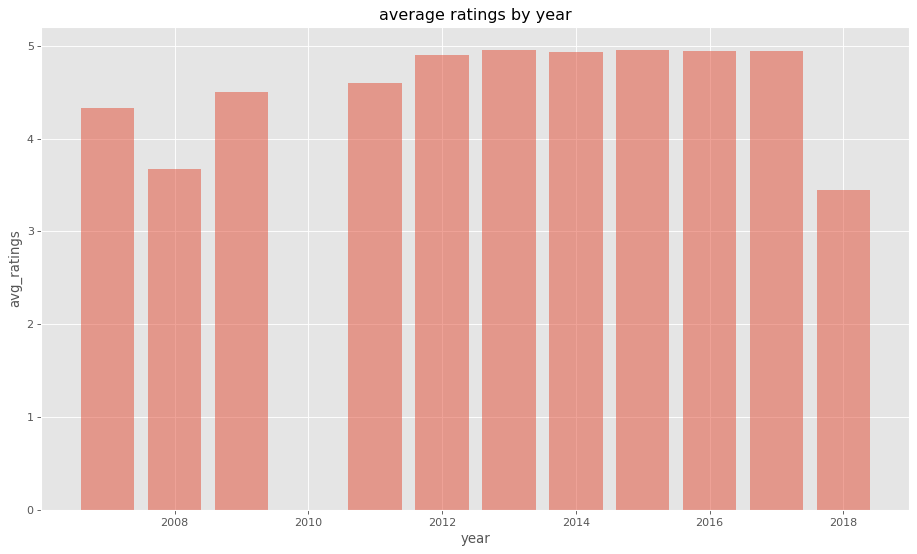

In [475]:
fig, ax = plt.subplots(figsize=(14, 8), dpi=80)
ax.bar(by_year_beauty['year'],by_year_beauty['avg_ratings'],alpha=0.5)
ax.set_title("average ratings by year")
ax.set_xlabel("year")
ax.set_ylabel("avg_ratings")

Text(0.5, 1.0, 'Distribution of ratings in Beauty')

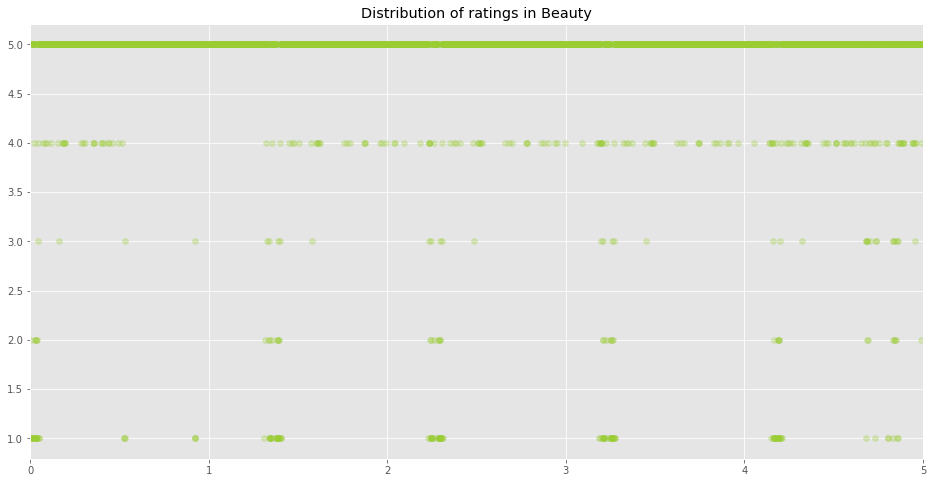

In [400]:
fig, ax = plt.subplots(1, figsize=(16, 8))

x = np.linspace(0, 5, num=4280)
ax.scatter(x, overall_beauty.collect(), color='yellowgreen',alpha=0.3)
ax.set_xlim(0, 5)
ax.set_title("Distribution of ratings in Beauty")
df_years_books = pd.DataFrame({'ratings': overall_books.collect(),
                             'years': years_books.collect()
})
df_years_books.head(5)

## Explore data in Books

In [149]:
ls data/

AMAZON_FASHION_5.json  All_Beauty_5.json      Books_5.json


In [151]:
# Books ratings
path_books = "data/Books_5.json"

In [152]:
# Create Spark DF
books_df = spark.read.json(path_books)
# Create Spark SQL
books_df.createOrReplaceTempView('books')
# Create Spark RDD
books_rdd = sc.textFile(path_books)


In [153]:
books_df.printSchema()



root
 |-- asin: string (nullable = true)
 |-- image: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- style: struct (nullable = true)
 |    |-- Color:: string (nullable = true)
 |    |-- Format:: string (nullable = true)
 |    |-- Package Quantity:: string (nullable = true)
 |    |-- Size:: string (nullable = true)
 |    |-- Style Name:: string (nullable = true)
 |    |-- Style:: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- verified: boolean (nullable = true)
 |-- vote: string (nullable = true)



In [154]:
books_rdd.take(1)

['{"overall": 5.0, "verified": false, "reviewTime": "03 30, 2005", "reviewerID": "A1REUF3A1YCPHM", "asin": "0001713353", "style": {"Format:": " Hardcover"}, "reviewerName": "TW Ervin II", "reviewText": "The King, the Mice and the Cheese by Nancy Gurney is an excellent children\'s book.  It is one that I well remember from my own childhood and purchased for my daughter who loves it.\\n\\nIt is about a king who has trouble with rude mice eating his cheese. He consults his wise men and they suggest cats to chase away the mice. The cats become a nuisance, so the wise men recommend the king bring in dogs to chase the cats away.  The cycle goes on until the mice are finally brought back to chase away the elephants, brought in to chase away the lions that\'d chased away the dogs.\\n\\nThe story ends in compromise and friendship between the mice and the king.  The story also teaches cause and effect relationships.\\n\\nThe pictures that accompany the story are humorous and memorable.  I was th

In [155]:
# Map each RDD item to JSON
books_rdd_json = books_rdd.map(parse_json)

# Sample View
books_rdd_json.take(1)

[{'overall': 5.0,
  'verified': False,
  'reviewTime': '03 30, 2005',
  'reviewerID': 'A1REUF3A1YCPHM',
  'asin': '0001713353',
  'style': {'Format:': ' Hardcover'},
  'reviewerName': 'TW Ervin II',
  'reviewText': "The King, the Mice and the Cheese by Nancy Gurney is an excellent children's book.  It is one that I well remember from my own childhood and purchased for my daughter who loves it.\n\nIt is about a king who has trouble with rude mice eating his cheese. He consults his wise men and they suggest cats to chase away the mice. The cats become a nuisance, so the wise men recommend the king bring in dogs to chase the cats away.  The cycle goes on until the mice are finally brought back to chase away the elephants, brought in to chase away the lions that'd chased away the dogs.\n\nThe story ends in compromise and friendship between the mice and the king.  The story also teaches cause and effect relationships.\n\nThe pictures that accompany the story are humorous and memorable.  I w

In [161]:
overall_books =(books_rdd_json.filter(lambda row: row['verified'])
                  .map(lambda row: row['overall'])
           )


In [162]:
overall_books.take(5)

[5.0, 5.0, 5.0, 5.0, 5.0]

In [264]:
mean_books = overall_books.mean()

In [265]:
std_books = overall_books.stdev()

In [167]:
years_books = (books_rdd_json.filter(lambda row: row['verified'])
                        .map(lambda row: row['reviewTime'])
                        .map(lambda row: row.split(","))
                        .map(lambda row: int(row[1]))
                       )
years_books.take(10)

[2016, 2016, 2015, 2013, 2013, 2012, 2016, 2015, 2015, 2014]

In [173]:
df_years_books = pd.DataFrame({'ratings': overall_books.collect(),
                             'years': years_books.collect()
})
df_years_books.head(5)

,ratings,years
0,5.0,2016
1,5.0,2016
2,5.0,2015
3,5.0,2013
4,5.0,2013


In [241]:
ratings_by_year_books = df_years_books.groupby('years')['ratings'].mean()
ratings_by_year_books

years
1997    4.463602
1998    4.409153
1999    4.305855
2000    4.297430
2001    4.288799
2002    4.302943
2003    4.325160
2004    4.268421
2005    4.246376
2006    4.284590
2007    4.344961
2008    4.307366
2009    4.305190
2010    4.272547
2011    4.253160
2012    4.318146
2013    4.388802
2014    4.415290
2015    4.440789
2016    4.455942
2017    4.482515
2018    4.506975
Name: ratings, dtype: float64

In [242]:
#convert Series to pd.dataframe
by_year_books = pd.DataFrame({'year': ratings_by_year_books.index.tolist(),
                  'avg_ratings': ratings_by_year_books})

by_year_books.reset_index(drop=True, inplace=True)
by_year_books

,year,avg_ratings
0,1997,4.463602
1,1998,4.409153
2,1999,4.305855
3,2000,4.297430
4,2001,4.288799
5,2002,4.302943
6,2003,4.325160
7,2004,4.268421
8,2005,4.246376
9,2006,4.284590


In [243]:
#ratings count

cnt_books = Counter(overall_books.collect())
cnt_books

KeyboardInterrupt: 

In [194]:
# Create DF of ratings count
df_cnt_books = pd.DataFrame({'ratings': list(cnt_books.keys()),
                             'count': list(cnt_books.values())
})
df_cnt_books = df_cnt_books.sort_values(by=['ratings'],ascending=False)
df_cnt_books


,ratings,count
0,5.0,12039326
2,4.0,3653877
4,3.0,1521282
1,2.0,632423
3,1.0,482549
5,0.0,1


Text(0.5, 1.0, 'Ratings count in Books')

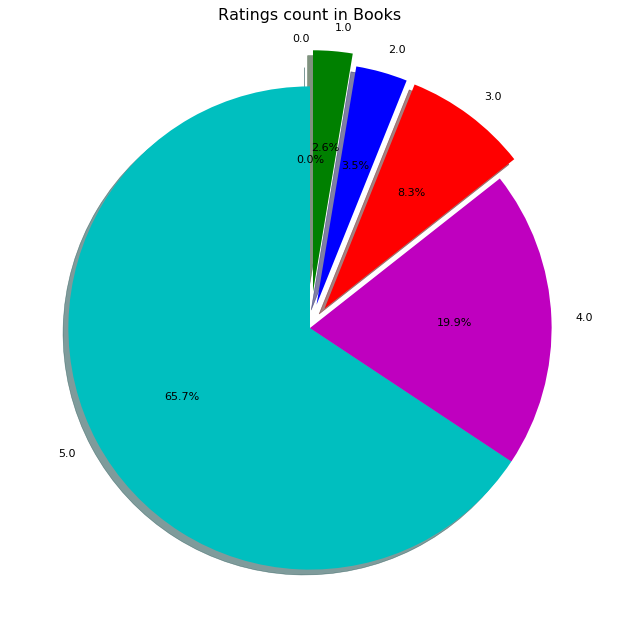

In [202]:
fig, ax = plt.subplots(figsize=(14, 10), dpi=80)
labels = df_cnt_books['ratings'].values
sizes  = df_cnt_books['count'].values
cols = ['c','m','r','b','g']
# ax.bar(df_ratings['ratings'],df_ratings['count'])
ax.pie(sizes,
        labels=labels,
        startangle=90,
        shadow= True,
        colors=cols,
        explode=(0,0,0.1,0.1,0.15,0.1),
        autopct='%1.1f%%')

ax.set_title("Ratings count in Books")

In [180]:
labels = df_cnt_books['ratings'].values
labels

array([5., 2., 4., 1., 3., 0.])

## Merge the data of the two categories

In [206]:
# merge the ratings count
cnt_merge = pd.merge(df_cnt_beauty,df_cnt_books, how = 'outer',on=['ratings']) 
cnt_merge = cnt_merge.rename(columns = {'count_x': 'beauty',
                                        'count_y': 'books'})
cnt_merge

,ratings,beauty,books
0,5.0,3931.0,12039326
1,4.0,164.0,3653877
2,3.0,35.0,1521282
3,2.0,39.0,632423
4,1.0,111.0,482549
5,0.0,NaN,1


In [423]:
# merge the average ratings
ave_ratings_merge = pd.DataFrame({'mean':[round(mean_beauty,4),4.4258],
                                   'std':[round(std_beauty,4),0.9661]},
                                index = ['beauty','books'])
ave_ratings_merge

,mean,std
beauty,4.8143,0.7304
books,4.4258,0.9661


In [446]:
# merge the average ratings by year
avg_year_merge = pd.merge(by_year_beauty,by_year_books, how = 'outer',on=['year']) 
avg_year_merge = avg_year_merge.rename(columns = {'avg_ratings_x': 'avg_beauty',
                                        'avg_ratings_y': 'avg_books'})
avg_year_merge = avg_year_merge.replace(np.nan, 0)
avg_year_merge = avg_year_merge.sort_values(by = 'year').reset_index(drop = True)
avg_year_merge

,year,avg_beauty,avg_books
0,1997,0.000000,4.463602
1,1998,0.000000,4.409153
2,1999,0.000000,4.305855
3,2000,0.000000,4.297430
4,2001,0.000000,4.288799
5,2002,0.000000,4.302943
6,2003,0.000000,4.325160
7,2004,0.000000,4.268421
8,2005,0.000000,4.246376
9,2006,0.000000,4.284590


## visualize the merged data 

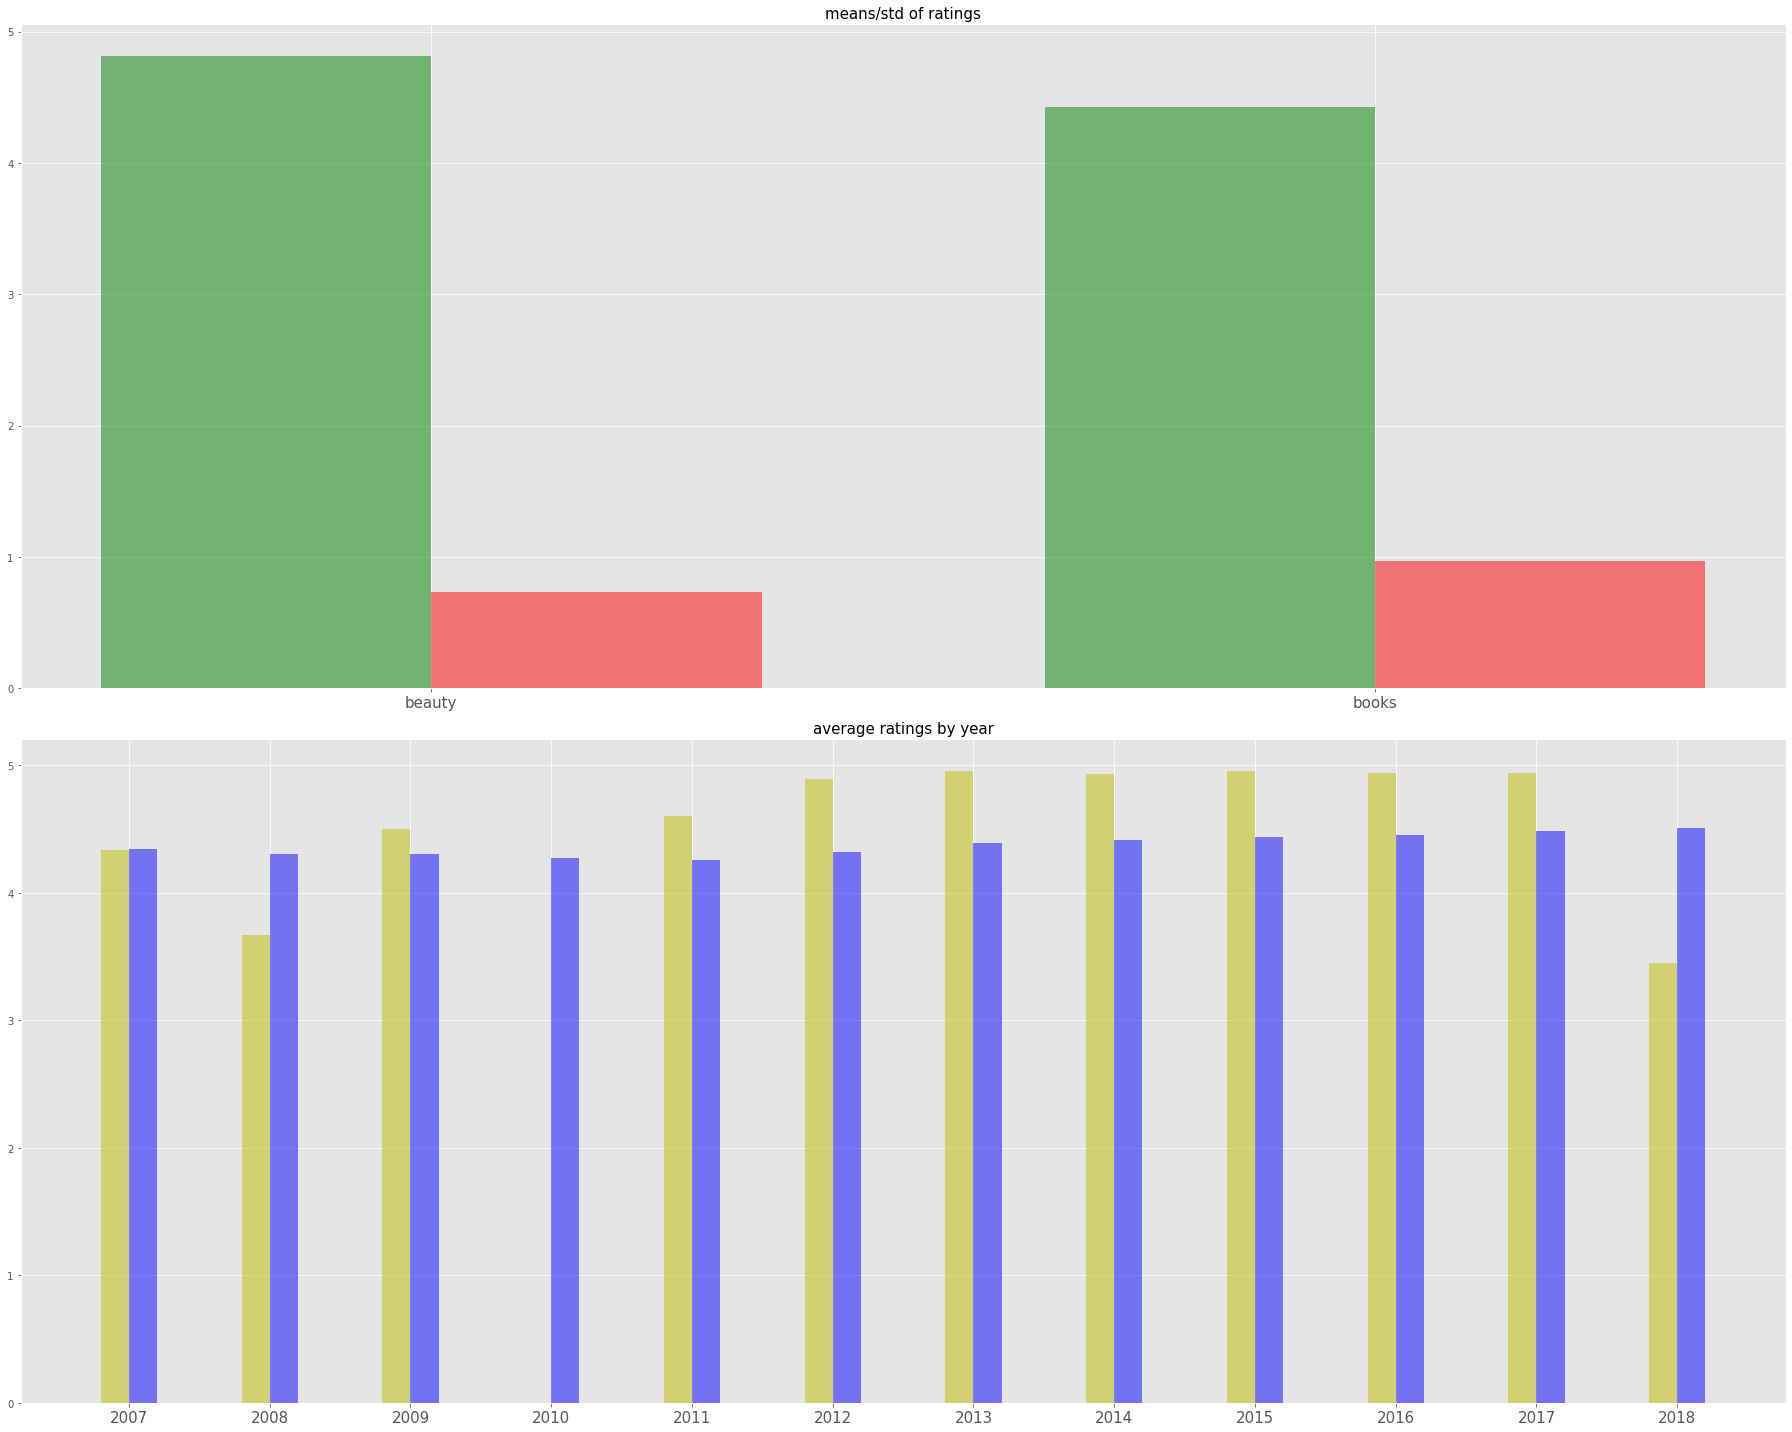

In [456]:
fig, axs = plt.subplots(2,1,figsize=(25,20))
barlabels = ave_ratings_merge.index.tolist()
x0= np.arange(len(barlabels))
width0 =0.35
bins0 = ave_ratings_merge['mean'].tolist()
bins1 = ave_ratings_merge['std'].tolist()

axs[0].bar(x0-width0/2,bins0,width0,color = 'g',alpha = 0.5,label='mean')
axs[0].bar(x0+width0/2,bins1,width0,color = 'r',alpha = 0.5,label='std')
axs[0].set_title('means/std of ratings',fontsize=15)
axs[0].set_xticks(x0)
axs[0].set_xticklabels(barlabels,fontsize=15)

barlabels1 = After_2007['year'].tolist()
x1= np.arange(len(barlabels1))
width1 =0.2
bins2 = After_2007['avg_beauty'].tolist()
bins3 = After_2007['avg_books'].tolist()

axs[1].bar(x1-width1/2,bins2,width1,color = 'y',alpha = 0.5,label="avg_beauty")
axs[1].bar(x1+width1/2,bins3,width1,color = 'b',alpha = 0.5,label="avg_books")
axs[1].set_title('average ratings by year',fontsize=15)
axs[1].set_xticks(x1)
axs[1].set_xticklabels(barlabels1,fontsize=15)
ax.legend()
plt.tight_layout()

In [454]:
#Amazon only started selling this category in 2007.
#Drop the data befor 2007 in Books 
After_2007= avg_year_merge[avg_year_merge['year']>=2007]
After_2007 = avg_year_merge2.reset_index(drop = True)
After_2007

,year,avg_beauty,avg_books
0,2007,4.333333,4.344961
1,2008,3.666667,4.307366
2,2009,4.500000,4.305190
3,2010,0.000000,4.272547
4,2011,4.600000,4.253160
5,2012,4.894737,4.318146
6,2013,4.951515,4.388802
7,2014,4.933222,4.415290
8,2015,4.957983,4.440789
9,2016,4.940147,4.455942


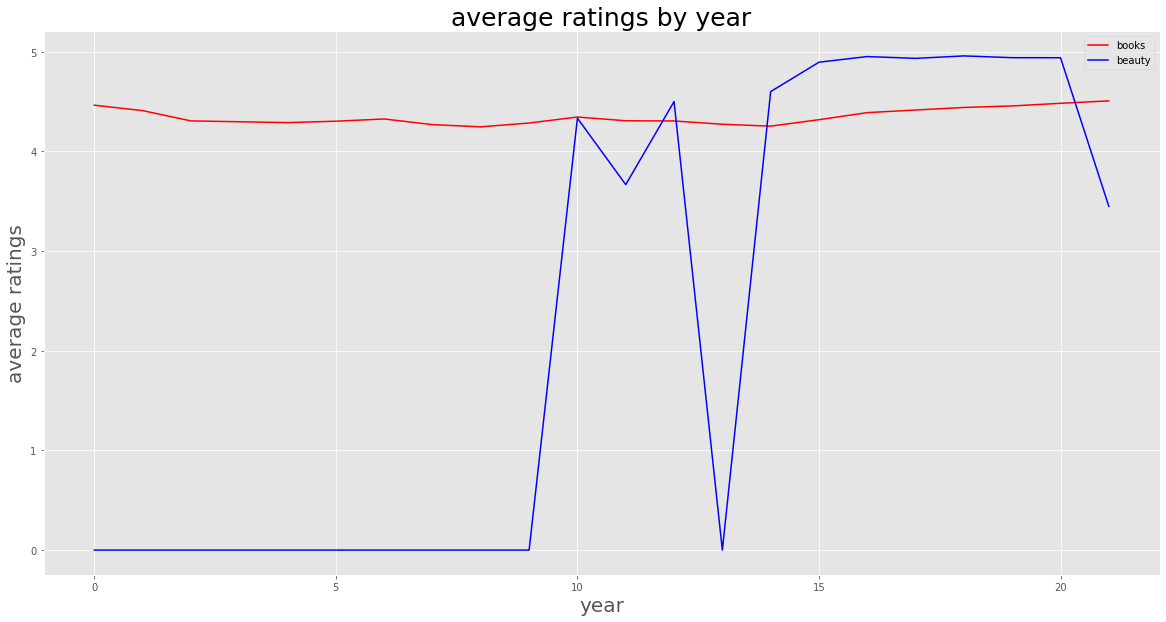

In [462]:
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(np.arange(len(avg_year_merge['year'])),avg_year_merge['avg_books'],color='r',label = 'books')
ax.plot(np.arange(len(avg_year_merge['year'])),avg_year_merge['avg_beauty'],color='b',label = 'beauty')
ax.set_xlabel("year",fontsize=20)
ax.set_ylabel("average ratings",fontsize=20)
ax.set_title('average ratings by year',fontsize=25)

ax.legend()

In [406]:
After_2007_books = df_years_books[df_years_books['years']>=2007]

After_2007_books =After_2007_books.reset_index(drop =True)
After_2007_books.count()

ratings    18152307
years      18152307
dtype: int64

In [509]:
After_2007_books.head(10)

,ratings,years
0,5.0,2016
1,5.0,2016
2,5.0,2015
3,5.0,2013
4,5.0,2013
5,5.0,2012
6,5.0,2016
7,5.0,2015
8,2.0,2015
9,5.0,2014


In [425]:
df_years.head(1)

,ratings,years
0,5.0,2016


In [427]:
stats.ttest_ind(After_2007_books.ratings,df_years.ratings)

Ttest_indResult(statistic=-26.242939596905792, pvalue=8.661683349929951e-152)

## Welch's t-test

### The average ratings from 2007 to 2018 between Beauty and  Books.

In [430]:
# H0: There is no difference in the average ratings of Beauty and Books.
# H1: The average ratings of Beauty and Books are different
# alpha: 0.01

In [554]:
ratings_ttest_all = stats.ttest_ind(After_2007_books.ratings,ratings_beauty.ratings)
print(ratings_ttest_all)

Ttest_indResult(statistic=-26.242939596905792, pvalue=8.661683349929951e-152)


In [ ]:
# p-value is small than alpha, there are enough advience to reject H0.
# The average ratings of Beauty and Books are different.

In [514]:
ratings_ttest_2018 = stats.ttest_ind(ratings_beauty_2018.ratings,
                                     After_2007_books.ratings)
print(ratings_ttest_2018)

Ttest_indResult(statistic=-19.222115304892696, pvalue=2.4216966678744823e-82)


In [504]:
ratings_beauty_2018 = ratings_beauty[ratings_beauty['years']==2018]
ratings_beauty_2018 = ratings_beauty_2018.reset_index(drop =True)
ratings_beauty_2018.head(5)

,ratings,years
0,2.0,2018
1,1.0,2018
2,1.0,2018
3,1.0,2018
4,1.0,2018


In [508]:
After_2007_books.tail(2)

,ratings,years
18152305,5.0,2016
18152306,5.0,2016


In [512]:
ratings_books_2018 = After_2007_books[After_2007_books['years']==2018]
ratings_books_2018 = ratings_books_2018.reset_index(drop =True)
ratings_books_2018.head(5)

,ratings,years
0,4.0,2018
1,5.0,2018
2,5.0,2018
3,5.0,2018
4,5.0,2018


In [ ]:
## fashion

In [526]:
path_fashion = 'data/AMAZON_FASHION_5.json'

In [527]:
# Create Spark RDD
fashion_rdd = sc.textFile(path_fashion)
# Map each RDD item to JSON
fashion_rdd_json = fashion_rdd.map(parse_json)

# Sample View
fashion_rdd_json.take(1)

[{'overall': 5.0,
  'verified': True,
  'reviewTime': '09 4, 2015',
  'reviewerID': 'ALJ66O1Y6SLHA',
  'asin': 'B000K2PJ4K',
  'style': {'Size:': ' Big Boys', 'Color:': ' Blue/Orange'},
  'reviewerName': 'Tonya B.',
  'reviewText': 'Great product and price!',
  'summary': 'Five Stars',
  'unixReviewTime': 1441324800}]

In [559]:
ratings_fashion = clean_data(fashion_rdd_json,'fashion')
ratings_fashion.head(5)

,ratings,years,category
0,5.0,2015,fashion
1,5.0,2015,fashion
2,5.0,2015,fashion
3,5.0,2015,fashion
4,5.0,2015,fashion
